# Approach 3 - Local Features
For this approach, we extract local features from the Lapse images using SIFT and cluster them into a vocabulary (Bag of Words approach). Using this vocabulary, we can map every Lapse and Motion image to a BoW feature vector. The Lapse feature vectors make up the training data for a one-class SVM. The decision boundary of the SVM can then be customized to achieve the right compromise between correct keeps and correct eliminations.
As we are using SIFT descriptors, we work on grayscale images.

## Advantages
- scale, rotation and position invariance = invariance to camera movements
- not sensitive to lighting changes


## Disadvantages
- no color information
- Instead of detecting the anomalies (animals), we detect the absence of a sufficiently large portion of the background. Smaller objects are therefore especially hard to detect.

In [2]:
%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

from py.Dataset import Dataset
from py.ImageUtils import display_images

DIR = '/home/kleinsteuber/vscode/ResizedSessions_NoBackup' # dataset directory

ds = Dataset(DIR)
session = ds.create_session("marten_01")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found 2 sessions
Session 'Marten_01' at folder: /home/kleinsteuber/vscode/ResizedSessions_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Marten_01
Loaded scans.


## Compute SIFT descriptors
Since there are often thousands of SIFT keypoints, we limit the number of keypoints to 400. To select larger keypoints (i.e. in higher octaves), we choose a larger sigma of 2.4 (default: 1.6).

/home/kleinsteuber/vscode/py/Session.py:275: UserWarning: There are multiple lapse images for date 2021-04-27 13:00:00! Choosing the first one.
  warn(f"There are multiple lapse images for date {previous_date}! Choosing the first one.")
/home/kleinsteuber/vscode/py/Session.py:277: UserWarning: There are multiple lapse images for date 2021-04-27 14:00:00! Choosing the first one.
  warn(f"There are multiple lapse images for date {next_date}! Choosing the first one.")


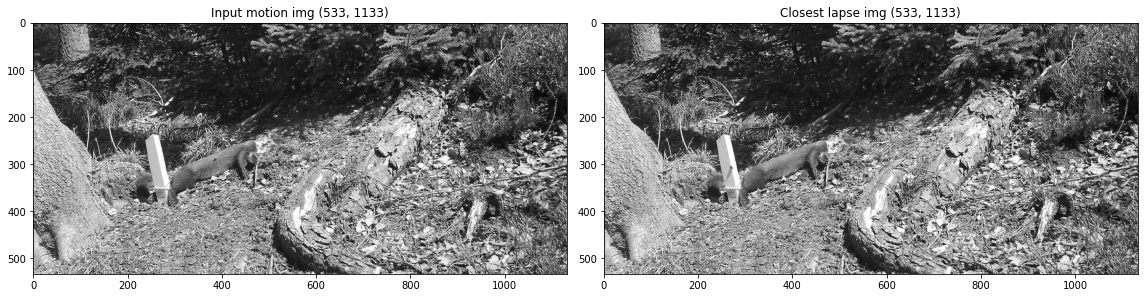

In [24]:
# Get motion image and closest lapse image for comparison
motion_img = session.get_random_motion_image(day_only=True)
before_img, after_img, rel = motion_img.get_closest_lapse_images()
closest_img = before_img if rel <= 0.5 else after_img

# read and display images
img = motion_img.read_opencv(gray=True)
comp_img = closest_img.read_opencv(gray=True)
display_images([img, comp_img], [f"Input motion img {img.shape}", f"Closest lapse img {comp_img.shape}"], cmap="gray")

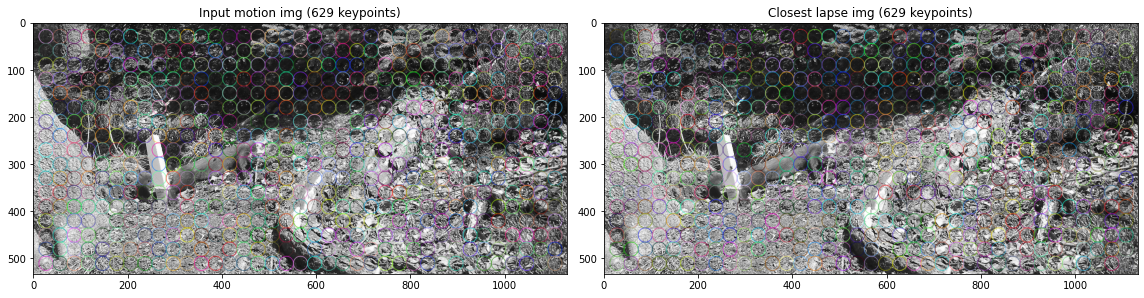

In [25]:
def dense_keypoints(img, step=30, off=(15, 12)):
    border_dist = (step + 1) // 2
    return [cv.KeyPoint(x, y, step) for y in range(border_dist + off[0], img.shape[0] - border_dist, step) 
                                    for x in range(border_dist + off[1], img.shape[1] - border_dist, step)]

sift = cv.SIFT_create()

img_kp = dense_keypoints(img)
img_kp, img_des = sift.compute(img, img_kp)

comp_img_kp = dense_keypoints(comp_img)
comp_img_kp, comp_img_des = sift.compute(comp_img, comp_img_kp)

kp_img = cv.drawKeypoints(img, img_kp, img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
comp_kp_img = cv.drawKeypoints(comp_img, comp_img_kp, comp_img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

display_images([kp_img, comp_kp_img], [f"Input motion img ({len(img_kp)} keypoints)", f"Closest lapse img ({len(comp_img_kp)} keypoints)"])

## Matching keypoints
We match SIFT descriptors against each other using a BF (brute-force) matcher. In the following, we match the keypoints of the lapse and motion image for testing purposes.

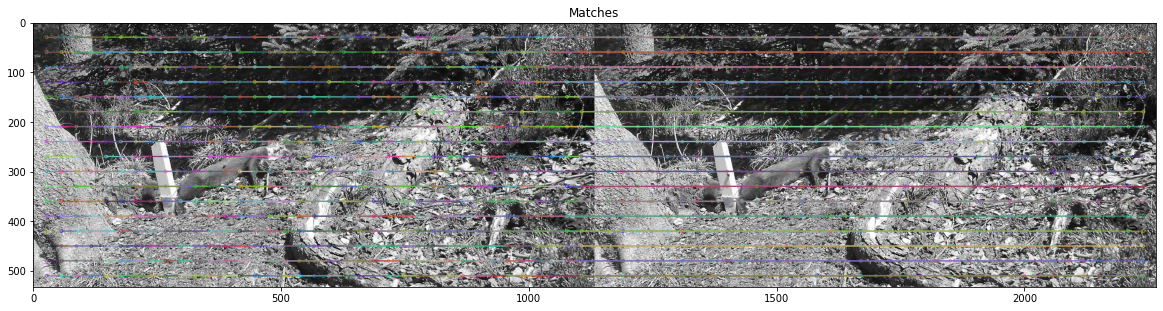

In [26]:
bf = cv.BFMatcher()
# Match descriptors, calculate best two matches
matches = bf.knnMatch(img_des, comp_img_des, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

# cv.drawMatchesKnn expects list of lists as matches.
matches_img = cv.drawMatchesKnn(img, img_kp, comp_img, comp_img_kp, good, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
display_images([matches_img], ["Matches"], size=(16,5))

## Evaluation

The test data must be labeled (normal/anomalous).

In [8]:
# test labels
from py.Labels import LABELS

clusters = 2048
test_labels = []
test_df = []
with open(f"./bow_train_NoBackup/{session.name}/bow_eval_{clusters}.csv", "r") as f:
    for line in f:
        filename, df = line.split(",")
        img_number = int(filename[10:-4])
        if img_number > LABELS[session.name]["max"]:
            continue
        is_normal = (img_number in LABELS[session.name]["normal"])
        test_labels.append(1 if is_normal else -1)
        test_df.append(float(df))
test_labels = np.array(test_labels)
test_df = np.array(test_df)

In [9]:
labeled_normal = np.mean(test_labels == 1)
print(f"{labeled_normal:.3f} labeled normal, {(1 - labeled_normal):.3f} anomalous")

0.837 labeled normal, 0.163 anomalous


In [10]:
def eval_test(df_threshold = 0):
    test_results = np.where(test_df >= df_threshold, np.ones(test_df.shape[0]), -np.ones(test_df.shape[0]))

    accuracy = np.mean(test_results == test_labels)
    tar = np.sum((test_results == 1) & (test_labels == 1)) / np.sum(test_labels == 1)
    tnr = np.sum((test_results == -1) & (test_labels == -1)) / np.sum(test_labels == -1)
    far = np.sum((test_results == 1) & (test_labels == -1)) / np.sum(test_labels == -1)
    fnr = np.sum((test_results == -1) & (test_labels == 1)) / np.sum(test_labels == 1)
    precision = (np.sum((test_results == 1) & (test_labels == 1)) / np.sum(test_results == 1)) if np.any(test_results == 1) else 0

    return accuracy, tar, tnr, far, fnr, precision

accuracy, tar, tnr, far, fnr, precision = eval_test()

print(f"Accuracy:                               {accuracy:.3f}")
print(f"True anomalous rate (must be high!):    {tar:.3f} \t - How many animals are detected as animals? (recall)")
print(f"True normal rate (higher is better):    {tnr:.3f} \t - How many empties are detected as empties?")
print(f"False anomalous rate (lower is better): {far:.3f} \t - How many empties are detected as animals?")
print(f"False normal rate (must be low!):       {fnr:.3f} \t - How many animals are detected as empties?")
print(f"Precision (higher is better):           {precision:.3f} \t - How many detected animals are actually animals?")

Accuracy:                               0.157
True anomalous rate (must be high!):    0.000 	 - How many animals are detected as animals? (recall)
True normal rate (higher is better):    0.959 	 - How many empties are detected as empties?
False anomalous rate (lower is better): 0.041 	 - How many empties are detected as animals?
False normal rate (must be low!):       1.000 	 - How many animals are detected as empties?
Precision (higher is better):           0.000 	 - How many detected animals are actually animals?


Since we want to find a compromise between a high number of correctly kept images (anomalies classified as anomalies, recall) and a high number of correctly eliminated images (normals classified as normals), we plot the two values against each other for various thresholds.

In [11]:
df_threshold_range = (-400, 100, 5)
eval_results = np.empty((len(range(*df_threshold_range)), 7))

for i, df_threshold in tqdm(enumerate(range(*df_threshold_range))):
    metrics = eval_test(df_threshold)
    eval_results[i] = [df_threshold, *metrics]

0it [00:00, ?it/s]

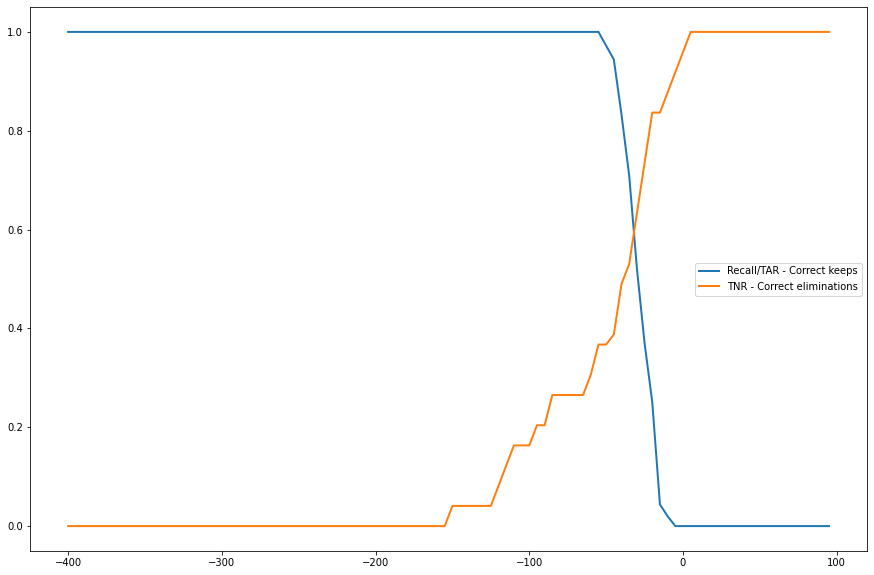

In [12]:
metrics_names = ["Accuracy", "Recall/TAR - Correct keeps", "TNR - Correct eliminations", "FAR", "FNR", "Precision"]
enable_metrics = [1, 2]
plt.figure(figsize=(15, 10))
for i, metrics_name in enumerate(metrics_names):
    if i in enable_metrics:
        plt.plot(eval_results[:,0], eval_results[:,(i+1)], label=metrics_name, linewidth=2)
plt.legend()
plt.show()